In [1]:
import spacy
import nltk
nlp=spacy.load('en_core_web_sm')
import re
import wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
nltk.download('all')
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [2]:
df=pd.read_csv('amazonreviews.tsv',sep='\t')

In [3]:
df.shape

(10000, 2)

In [4]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  object
 1   review  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [6]:
### missing values
df.isnull().sum()

,0
label,0
review,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
#### Data cleaning
def data_clean(text):
  text1=' '.join(re.findall('\w+',text))
  doc=nlp(text1)
  clean_text=[token.lemma_ for token in doc if not token.is_stop and not token.is_punct
              and not token.is_digit and not token.is_bracket and not token.is_currency]
  return clean_text

In [9]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [11]:
df['word_count']=df['review'].apply(lambda x:len(x.split()))

In [12]:
df.head()

,label,review,word_count
0,pos,Stuning even for the non-gamer: This sound tra...,80
1,pos,The best soundtrack ever to anything.: I'm rea...,97
2,pos,Amazing!: This soundtrack is my favorite music...,129
3,pos,Excellent Soundtrack: I truly like this soundt...,118
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",87


In [13]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

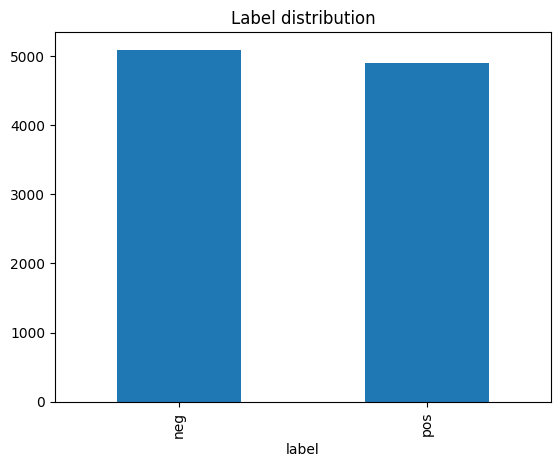

In [15]:
# 1. Sentiment distribution
df['label'].value_counts().plot(kind='bar')
plt.title("Label distribution")
plt.show()

In [18]:
# 2. Top words in positive / negative
pos_text = " ".join(df.loc[df.label=='pos', 'review'])
neg_text = " ".join(df.loc[df.label=='neg', 'review'])

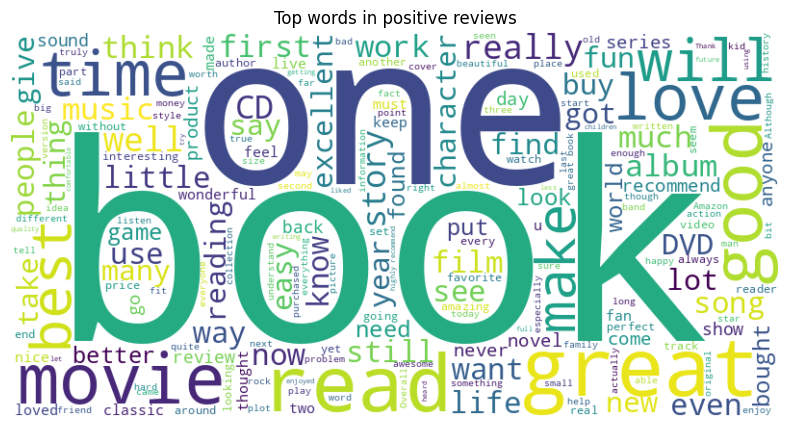

In [32]:
# Generate word cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Top words in positive reviews')
plt.show()

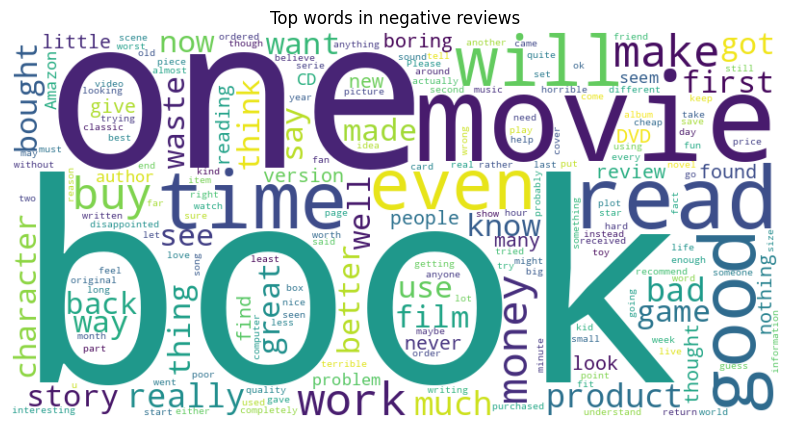

In [21]:
# Generate word cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Top words in negative reviews')
plt.show()

In [25]:
df['clean_text'] = df['review'].apply(data_clean)
display(df.head())

,label,review,word_count,clean_text
0,pos,Stuning even for the non-gamer: This sound tra...,80,"[stun, non, gamer, sound, track, beautiful, pa..."
1,pos,The best soundtrack ever to anything.: I'm rea...,97,"[good, soundtrack, m, read, lot, review, say, ..."
2,pos,Amazing!: This soundtrack is my favorite music...,129,"[amazing, soundtrack, favorite, music, time, h..."
3,pos,Excellent Soundtrack: I truly like this soundt...,118,"[Excellent, Soundtrack, truly, like, soundtrac..."
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",87,"[remember, pull, Jaw, floor, hear, ve, play, g..."


In [26]:
### feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform([' '.join(text) for text in df['clean_text']])
y = df['label'].map({'pos':1, 'neg':0})

In [27]:
### model:Logistic Regression on TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

clf = LogisticRegression(max_iter=1000, C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1019
           1       0.85      0.84      0.84       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [28]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(X_train, y_train)
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1019
           1       0.84      0.83      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [29]:
### Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_tfidf, y, cv=skf, scoring='f1_macro')
print("CV f1_macro:", scores.mean(), scores.std())

CV f1_macro: 0.8544491914223962 0.004776445941615181


In [30]:
###Both Logistic Regression and SVM are performing very similarly, achieving ~84–85% accuracy and F1-score.

###This indicates that your feature extraction (TF-IDF) and text preprocessing are strong and consistent.

###The cross-validation F1 (0.854) shows low variance (±0.0048) — meaning the model generalizes well across different data splits

In [31]:
### Cross-validation Insight
### Mean F1 = 0.854
### Std dev = 0.0048 → indicates stable performance across folds.
### No sign of overfitting or major data imbalance issues.